<table><tr>
    <td><img src="logos/JPL-NASA-logo_583x110.png" alt="JPL/NASA logo" style="height: 75px"/></td>
    <td><img src="logos/CEOS-LOGO.png" alt="CEOS logo" style="height: 75px"/></td>
    <td><img src="logos/CoverageLogoFullClear.png" alt="COVERAGE logo" style="height: 100px"/></td>
</tr></table>

# _Analytics Examples for COVERAGE_

# Important Notes 
When you first connected you should have seen two notebook folders, `coverage` and `work`.  The original version of this notebook is in the `coverage` folder and is read-only.  If you would like to modify the code samples in this notebook, please first click `File`->`Save as...` to save your own copy in the `work` folder instead, and make your modifications to that copy. 

We don't yet have resources in place to support a true multi-user environment for notebooks.  This means that all saved notebooks are visible to all users. Thus, it would help to include your own unique identifier in the notebook name to avoid conflicts with others.  

Furthermore, we do not guarantee to preserve the saved notebooks for any period of time.  If you would like to keep your notebook, please remember to click `File`->`Download as`->`Notebook (.ipynb)` to download your own copy of the notebook at the end of each editting session.

# Notebook Setup

In the cell below are a few functions that help with plotting data using matplotlib. You shouldn't need to modify or pay much attention to this cell. Just run the cell to define the functions so that they can be used in the rest of the notebook.

In [1]:
%matplotlib inline
#######################################################################################
# In some jupyter deployments you will get an error about PROJ_LIB not being defined.
# In that case, uncomment these lines and set the directory to the location of your
# proj folder.
# import os
# import sys
# # Find where we are on the computer and make sure it is the pyICM directory
# HomeDir = os.path.expanduser('~')  # get the home directory

# ICMDir = HomeDir + "Desktop/AIST_Project/SDAP_Jupyter"
# # Navigate to the home directory
# os.chdir(ICMDir)
# print('Moved to Directory',ICMDir)

# module_path = os.path.join(ICMDir,'code')
# print('Code Directory is',module_path)
# print('Adding to the system path')
# if module_path not in sys.path:
#     sys.path.append(module_path)
#######################################################################################
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
# from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs #added by B Clark because Basemap is deprecated
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
import types
import math
import sys
import time
import requests
from datetime import datetime
import itertools
from shapely.geometry import box
from pprint import pprint, pformat
import textwrap
import warnings
warnings.filterwarnings("ignore")

# ISO-8601 date format
dt_format = "%Y-%m-%dT%H:%M:%SZ"

def show_plot(x_data, y_data, x_label=None, y_label=None, title=None):
    """
    Display a simple line plot.
    
    :param x_data: Numpy array containing data for the X axis
    :param y_data: Numpy array containing data for the Y axis
    :param x_label: Label applied to X axis
    :param y_label: Label applied to Y axis
    """
    plt.figure(figsize=(6,3), dpi=100)
    plt.plot([datetime.fromtimestamp(x_val) for x_val in x_data], y_data, 'b-', marker='|', markersize=2.0, mfc='b')
    plt.grid(b=True, which='major', color='k', linestyle='-')
    if title is not None:
        plt.title(title)
    if x_label is not None:
        plt.xlabel(x_label)
    if y_label is not None:
        plt.ylabel (y_label)
    plt.xticks(rotation=45)
    ts_range = x_data[-1] - x_data[0]

    # Define the time formatting
    if ts_range > 189216000: # 6 years
        dtFmt = mdates.DateFormatter('%Y')
    elif ts_range > 15552000: # 6 months
        dtFmt = mdates.DateFormatter('%b %Y')
    else: # < 6 months
        dtFmt = mdates.DateFormatter('%b %-d, %Y')

    plt.gca().xaxis.set_major_formatter(dtFmt)
    plt.show()

def plot_box(bbox):
    """
    Display a Green bounding box on an image of the blue marble.
    
    :param bbox: Shapely Polygon that defines the bounding box to display
    """
    min_lon, min_lat, max_lon, max_lat = bbox.bounds
    import matplotlib.pyplot as plt1
    import cartopy.crs as ccrs #added by B Clark because Basemap is deprecated
    # modified 11/30/2021 to use Cartopy toolbox B Clark NASA GSFC
    # from matplotlib.patches import Polygon
    # from mpl_toolkits.basemap import Basemap
    from shapely.geometry.polygon import Polygon
    # map = Basemap()
    # map.bluemarble(scale=0.5)
    # poly = Polygon([(min_lon,min_lat),(min_lon,max_lat),(max_lon,max_lat),(max_lon,min_lat)],
    #                facecolor=(0,0,0,0.0),edgecolor='green',linewidth=2)
    # plt1.gca().add_patch(poly)
    # plt1.gcf().set_size_inches(10,15)
    ax = plt1.axes(projection=ccrs.PlateCarree())
    ax.stock_img()
    # plt.show()     
    poly = Polygon(((min_lon,min_lat),(min_lon,max_lat),(max_lon,max_lat),(max_lon,min_lat),(min_lon,min_lat)))
    ax.add_geometries([poly],crs=ccrs.PlateCarree(),facecolor='b', edgecolor='red', alpha=0.8)
    # ax.fill(x, y,  color='coral', alpha=0.4)
    # plt1.gca().add_patch(poly)
    # plt1.gcf().set_size_inches(10,15)
    plt1.show()

def show_plot_two_series(x_data_a, x_data_b, y_data_a, y_data_b, x_label, 
                         y_label_a, y_label_b, series_a_label, series_b_label,
                         title=''):
    """
    Display a line plot of two series
    
    :param x_data_a: Numpy array containing data for the Series A X axis
    :param x_data_b: Numpy array containing data for the Series B X axis
    :param y_data_a: Numpy array containing data for the Series A Y axis
    :param y_data_b: Numpy array containing data for the Series B Y axis
    :param x_label: Label applied to X axis
    :param y_label_a: Label applied to Y axis for Series A
    :param y_label_b: Label applied to Y axis for Series B
    :param series_a_label: Name of Series A
    :param series_b_label: Name of Series B
    """ 
    font_size=12
    plt.rc('font', size=font_size)          # controls default text sizes
    plt.rc('axes', titlesize=font_size)     # fontsize of the axes title
    plt.rc('axes', labelsize=font_size)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('legend', fontsize=font_size)    # legend fontsize
    plt.rc('figure', titlesize=font_size)  # fontsize of the figure title
    fig, ax1 = plt.subplots(figsize=(10,5), dpi=100)
    series_a, = ax1.plot(x_data_a, y_data_a, 'b-', marker='|', markersize=2.0, mfc='b', label=series_a_label)
    ax1.set_ylabel(y_label_a, color='b')
    ax1.tick_params('y', colors='b')
    ax1.set_ylim(min(0, *y_data_a), max(y_data_a)+.1*max(y_data_a))
    ax1.set_xlabel(x_label)
    
    ax2 = ax1.twinx()
    series_b, = ax2.plot(x_data_b, y_data_b, 'r-', marker='|', markersize=2.0, mfc='r', label=series_b_label)
    ax2.set_ylabel(y_label_b, color='r')
    ax2.set_ylim(min(0, *y_data_b), max(y_data_b)+.1*max(y_data_b))
    ax2.tick_params('y', colors='r')
    
    plt.grid(b=True, which='major', color='k', linestyle='-')
    plt.legend(handles=(series_a, series_b), bbox_to_anchor=(1.1, 1), loc=2, borderaxespad=0.)
    plt.title(title)
    plt.show()

def ts_plot_two(ts_json1, ts_json2, dataset1, dataset2, units1, units2,
            title='', t_name='time', val_name='mean'):
    t1 = np.array([ts[0][t_name] for ts in ts_json1["data"]])
    t2 = np.array([ts[0][t_name] for ts in ts_json2["data"]])
    vals1 = np.array([ts[0][val_name] for ts in ts_json1["data"]])
    vals2 = np.array([ts[0][val_name] for ts in ts_json2["data"]])
    show_plot_two_series(t1, t2, vals1, vals2, "time (sec since 1970-01-01T00:00:00)",
                         units1, units2, dataset1, dataset2, title=title)

def scatter_plot(ts_json1, ts_json2, t_name="time", val_name="mean",
                title="", xlabel="", ylabel=""):
    times1 = np.array([ts[0][t_name] for ts in ts_json1["data"]])
    times2 = np.array([ts[0][t_name] for ts in ts_json2["data"]])
    vals1 = np.array([ts[0][val_name] for ts in ts_json1["data"]])
    vals2 = np.array([ts[0][val_name] for ts in ts_json2["data"]])
    vals_x = []
    vals_y = []
    for i1,t1 in enumerate(times1):
        i = (np.abs(times2-times1[i1])).argmin()
        if np.abs(times1[i1]-times2[i]) < 86400: # 24 hrs
            vals_x.append(vals1[i1])
            vals_y.append(vals2[i])
    plt.scatter(vals_x, vals_y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def roundBorders(borders, borderSlop=10.):
    b0 = roundBorder(borders[0], 'down', borderSlop,   0.)
    b1 = roundBorder(borders[1], 'down', borderSlop, -90.)
    b2 = roundBorder(borders[2],   'up', borderSlop, 360.)
    b3 = roundBorder(borders[3],   'up', borderSlop,  90.)
    return [b0, b1, b2, b3]

def roundBorder(val, direction, step, end):
    if direction == 'up':
        rounder = math.ceil
        slop = step
    else:
        rounder = math.floor
        slop = -step
###    v = rounder(val/step) * step + slop                                      
    v = rounder(val/step) * step
    if abs(v - end) < step+1.: v = end
    return v

def normalizeLon(lon):
    if lon < 0.: return lon + 360.
    if lon > 360.: return lon - 360.
    return lon

def normalizeLons(lons):
    return np.array([normalizeLon(lon) for lon in lons])

def ensureItems(d1, d2):
    for key in d2.keys():
        if key not in d1: d1[key] = d2[key]

CmdOptions = {'MCommand':  ['title', 'xlabel', 'ylabel',  'xlim', 'ylim', 'show\
'],
   	      'plot':      ['label', 'linewidth', 'legend', 'axis'],
              'map.plot':  ['label', 'linewidth', 'axis'],
              'map.scatter':  ['norm', 'alpha', 'linewidths', 'faceted', 'hold'\
],
              'savefig':   ['dpi', 'orientation']
              }

def die(*s):   warn('Error,',  *s); sys.exit()
    
def evalKeywordCmds(options, cmdOptions=CmdOptions):
    for option in options:
        if option in cmdOptions['MCommand']:
            args = options[option]
            if args:
                if args is True:
                    args = ''
                else:
                    args = "'" + args + "'"
                if option in cmdOptions:
                    args += dict2kwargs( validCmdOptions(options, cmdOptions[option]) )
                try:
                    eval('plt.' + option + '(%s)' % args)
                except:
                    die('failed eval of keyword command option failed: %s=%s' % (option, args))

def validCmdOptions(options, cmd, possibleOptions=CmdOptions):
    return dict([(option, options[option]) for option in options.keys()
                    if option in possibleOptions[cmd]])

def dict2kwargs(d):
    args = [',%s=%s' % (kw, d[kw]) for kw in d]
    return ', '.join(args)

def imageMap(lons, lats, vals, vmin=None, vmax=None, 
             imageWidth=None, imageHeight=None, outFile=None,
             projection='cyl', cmap=plt.cm.jet, logColors=False, makeFigure=False,
             borders=[0., -90., 360., 90.], autoBorders=True, borderSlop=10.,
             meridians=[0, 360, 60], parallels=[-60, 90, 30], title='', normalizeLongs=True,
             **options):
    if normalizeLongs:
        lons = normalizeLons(lons)
    if vmin == 'auto': vmin = None
    if vmax == 'auto': vmax = None
    if imageWidth is not None: makeFigure = True
    if projection is None or projection == '': projection = 'cyl'
    if cmap is None or cmap == '': cmap = plt.cm.jet
    #if isinstance(cmap, types.StringType) and cmap != '':
    if isinstance(cmap, str) and cmap != '':
        try:
            cmap = eval('plt.cm.' + cmap)
        except:
            cmap = plt.cm.jet

    ensureItems(options, { \
                     'title': title, 'dpi': 100,
                     'imageWidth': imageWidth or 1024, 'imageHeight': imageHeight or 768})
    if autoBorders:
        borders = [min(lons), min(lats), max(lons), max(lats)]
        borders = roundBorders(borders, borderSlop)

    #m = Basemap(borders[0], borders[1], borders[2], borders[3], \
    #            projection=projection, lon_0=np.average([lons[0], lons[-1]]))

    if makeFigure:
        dpi = float(options['dpi'])
        width = float(imageWidth) / dpi
        height = width
        #if imageHeight is None:
        #    height = width * m.aspect
        #else:
        #    height = float(imageHeight) / dpi
        #plt.figure(figsize=(width,height)).add_axes([0.1,0.1,0.8,0.8], frameon=True)
        plt.figure(figsize=(width,height))
        m = plt.axes(projection=ccrs.PlateCarree())
        #m.set_extent([meridians[0], meridians[1], parallels[0], parallels[1]],
        #             crs=ccrs.PlateCarree())
        gl = m.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                         linewidth=2, color='gray', alpha=0.5, linestyle='--')
        gl.xlabels_top = False
        gl.ylabels_left = True
        gl.ylabels_right = False
        gl.xlines = True
        gl.ylines = True
        gl.xlocator = mticker.FixedLocator(np.arange(meridians[0], meridians[1]+meridians[2], meridians[2]))
        gl.ylocator = mticker.FixedLocator(np.arange(parallels[0], parallels[1]+parallels[2], parallels[2]))
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 12, 'color': 'black'}
        gl.ylabel_style = {'size': 12, 'color': 'black'}
        
    if vmin is not None or vmax is not None: 
        if vmin is None:
            vmin = np.min(vals)
        else:
            vmin = float(vmin)
        if vmax is None:
            vmax = np.max(vals)
        else:
            vmax = float(vmax)
        #vrange = (vmax - vmin) / 255.
        #levels = np.arange(vmin, vmax, vrange/30.)
        levels = np.linspace(vmin, vmax, 256)
    else:
        levels = 30

    if logColors:
        norm = mcolors.LogNorm(vmin=vmin, vmax=vmax)
    else:
        norm = None
    # x, y = m(*np.meshgrid(lons,lats))
    x, y = np.meshgrid(lons,lats)
    c = m.contourf(x, y, vals, levels, cmap=cmap, colors=None, norm=norm)
    # m.drawcoastlines()
    m.coastlines()
    #m.drawmeridians(range(meridians[0], meridians[1], meridians[2]), labels=[0,0,0,1])
    #m.drawparallels(range(parallels[0], parallels[1], parallels[2]), labels=[1,1,1,1])
    plt.colorbar(c, ticks=np.linspace(vmin,vmax,7), shrink=0.6)
    evalKeywordCmds(options)
    if outFile:
        plt.savefig(outFile, **validCmdOptions(options, 'savefig'))
    
def arr2d_from_json(js, var_name):
    return np.array([[js[i][j][var_name] for j in range(len(js[0]))] for i in range(len(js))])

def arr1d_from_json(js, var_name):
    return np.array([js[i][var_name] for i in range(len(js))])

def plot_map(map, val_key="mean", cnt_key="cnt", lon_key="lon", lat_key="lat", fill=-9999, grid_line_sep=10,
             border_slop=1, log_colors=False, title='', vmin=None, vmax=None, 
             normalize_lons=False, image_width=1000, **options):
    # Parse values, longitudes and latitudes from JSON response.
    vals = arr2d_from_json(map, val_key)
    cnts = arr2d_from_json(map, cnt_key)
    lons = arr1d_from_json(map[0], lon_key)
    lats = arr1d_from_json([map[i][0] for i in range(len(map))], lat_key)
    
    # If cnt is 0, set value to fill
    vals[cnts==0] = fill
    
    # Plot time time-averaged map as an image.
    print("Creating plot of the results.")
    print("This will take a minute.  Please wait...")
    min_val = np.min(vals[vals != fill])
    if vmin is None:
        vmin = min_val
    max_val = np.max(vals[vals != fill])
    if vmax is None:
        vmax = max_val
    min_lon = math.floor(np.min(lons)) - grid_line_sep
    max_lon = math.ceil(np.max(lons))
    min_lat = math.floor(np.min(lats)) - grid_line_sep
    max_lat = math.ceil(np.max(lats))
    imageMap(lons, lats, vals, imageWidth=image_width, vmin=vmin, vmax=vmax, logColors=log_colors,
             meridians=[min_lon, max_lon, grid_line_sep], 
             parallels=[min_lat, max_lat, grid_line_sep], borderSlop=border_slop, 
             title=title, normalizeLongs=normalize_lons, **options)
    
def ts_plot(ts_json, t_name='time', val_name='mean', 
            title='', units=''):
    t = np.array([ts[0][t_name] for ts in ts_json["data"]])
    vals = np.array([ts[0][val_name] for ts in ts_json["data"]])
    show_plot(t, vals, title=textwrap.fill(title,64),
              y_label=textwrap.fill(units,32))

def plot_hovmoller(hm, time_key="time", val_key="mean",
                   coord_series_key="lats", coord_point_key="latitude",
                   coord_axis_vert=True, fill=-9999.,
                   hovfig=None, subplot=111, add_color_bar=True,
                   title=""):
    times = [d[time_key] for d in hm]
    times = mdates.epoch2num(times)
    coords = [[d[coord_point_key] for d in hvals[coord_series_key]]
               for hvals in hm]
    coords_flat = np.array(sorted(list(set(itertools.chain(*coords)))))
    coords_delta = np.median(coords_flat[1:] - coords_flat[:-1])
    coords_min = np.amin(coords_flat)
    coords_max = np.amax(coords_flat)
    vals_fill = np.full((len(hm),len(coords_flat)), fill, dtype=np.float64)
    t_ind = 0
    for hvals in hm:
        cur_vals = np.array([d[val_key] for d in hvals[coord_series_key]])
        coords = np.array([d[coord_point_key] for d in hvals[coord_series_key]])
        coords_inds = np.round((coords - coords_min) /
                               coords_delta).astype(int)
        vals_fill[t_ind, coords_inds] = cur_vals
        t_ind += 1
    vals = np.ma.array(data=vals_fill, mask=vals_fill == fill)
    extent = [np.min(times), np.max(times), coords_min, coords_max]
    dtFmt = mdates.DateFormatter('%b %Y') # define the formatting
    if hovfig is None:
        fig = plt.figure(figsize=(16,6))
    else:
        fig = hovfig
    ax = fig.add_subplot(subplot)
    ax.set_title(title)
    if coord_axis_vert:
        vals = np.transpose(vals)
        ax.xaxis.set_major_formatter(dtFmt)
        ax.set_ylabel(coord_point_key)
        plt.xticks(rotation=45)
    else:
        extent = [extent[2], extent[3], extent[0], extent[1]]
        ax.yaxis.set_major_formatter(dtFmt)
        ax.set_xlabel(coord_point_key)
    cax = ax.imshow(vals, origin='lower', extent=extent)
    ax.set_aspect('auto')
    if add_color_bar:
        fig.colorbar(cax, ticks=np.linspace(np.min(vals), np.max(vals), 7),
                     orientation='vertical')
    return fig

def compute_ts_and_tam_no_plot(dataset, bbox, start_time, end_time, base_url="localhost",
                               seasonal_filter="false"):
    url_params = 'ds={}&minLon={}&minLat={}&maxLon={}&maxLat={}&startTime={}&endTime={}'.\
        format(dataset, *bbox.bounds, 
               start_time.strftime(dt_format), end_time.strftime(dt_format))
    ts_url = '{}/timeSeriesSpark?{}&seasonalFilter={}'.format(base_url, url_params,
                                                              seasonal_filter)
    tam_url = '{}/timeAvgMapSpark?{}'.format(base_url, url_params)

    # Display some information about the job
    print(ts_url); print()
    print(tam_url); print()

    # Query SDAP to compute the time series
    print("Computing time series...")
    start = time.perf_counter()
    ts_json = requests.get(ts_url, verify=False).json()
    print("Area-averaged time series took {} seconds".format(time.perf_counter() - start))
    print()
    
    # Query SDAP to compute the time averaged map
    print("Computing time averaged map...")
    start = time.perf_counter()
    tam_json = requests.get(tam_url, verify=False).json()
    print("Time averaged map took {} seconds".format(time.perf_counter() - start))
    return ts_json, tam_json

def compute_ts_and_tam(dataset, bbox, start_time, end_time, base_url="localhost",
                       seasonal_filter="false", title='', grid_line_sep=5,
                       units=None, log_colors=False, normalize_lons=False, **options):
    ts_json, tam_json = compute_ts_and_tam_no_plot(dataset, bbox, start_time, end_time,
                                                   base_url=base_url,
                                                   seasonal_filter=seasonal_filter)
    print()
    print("Plot of area-average time series:")
    ts_plot(ts_json, val_name='mean', title=title, units=units)
    if seasonal_filter == "true":
        print("Plot of time series of difference with climatology:")
        ts_plot(ts_json, val_name='meanSeasonal',
                title=title, units=units)
        print()
    
    # Query SDAP to compute the time averaged map
    tam = tam_json["data"]
    plot_map(tam, log_colors=log_colors, grid_line_sep=grid_line_sep, title=title, 
             normalize_lons=normalize_lons, **options)

def show_sdap_json(j, nh=20, nt=10):
    out_str = pformat(j)
    for line in out_str.splitlines()[:nh]:
        print(line)
    print("\t\t.\n"*3)
    for line in out_str.splitlines()[-nt:]:
        print(line)

print('Done with plotting setup.')

Done with plotting setup.


# Science Data Analytics Platform (SDAP)
SDAP (https://sdap.apache.org/) provides advanced analytics capabilities to support NASA's New Observing Strategies (NOS) and Analytic Collaborative Frameworks (ACF) thrusts.  In this demonstration we use SDAP with oceanographic datasets relevant to the CEOS Ocean Variables Enabling Research and Applications for GEO (COVERAGE) initiative.

In this demonstration, two geographically distributed SDAP cloud computing deployments are used, one on Amazon Web Services (AWS, https://aws.amazon.com/) for analytics with datasets curated in the USA (e.g., from NASA or NOAA), and one on WEkEO (https://www.wekeo.eu/) for analytics with European datasets (e.g., from CMEMS).  In this way we follow the strategy of performing the computations close to the data host providers.

SDAP provides web service endpoints for each analytic algorithm, and can be accessed in a web browser or from a variety of programming languages.  This notebook demonstrates the Python API to access SDAP.

## Demonstration Setup

In the cell below, we specify the location of the SDAP deployments to use, a dataset to be used, the 
bounding box for an area of interest, and a time range for analysis.

dataset_us: MUR25-JPL-L4-GLOB-v4.2_analysed_sst
dataset_eu: METOFFICE-GLO-SST-L4-NRT-OBS-GMPE-V3_analysed_sst
spatial region POLYGON ((-70 35, -70 42, -77 42, -77 35, -70 35)), and time range 2018-01-01 00:00:00 to 2018-12-31 00:00:00.


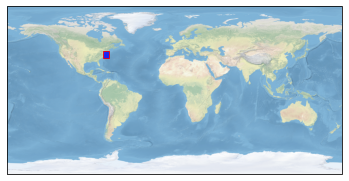

In [2]:
# Base URLs for the USA (AWS) and European (WEkEO) SDAP deployments.
base_url_us = "https://coverage.ceos.org/nexus"
base_url_eu = "https://coverage.wekeo.eu"

# Define bounding box and time period for analysis
min_lon = -77; max_lon = -70
min_lat = 35; max_lat = 42
bbox = box(min_lon, min_lat, max_lon, max_lat)

# Specify the SDAP name of the datasets
dataset_us = "MUR25-JPL-L4-GLOB-v4.2_analysed_sst"
dataset_eu = "METOFFICE-GLO-SST-L4-NRT-OBS-GMPE-V3_analysed_sst"
start_time = datetime(2018, 1, 1)
end_time = datetime(2018, 12, 31)

print("dataset_us: {}".format(dataset_us))
print("dataset_eu: {}".format(dataset_eu))
print("spatial region {}, and time range {} to {}.".
      format(bbox, start_time, end_time))
plot_box(bbox)

# Cloud Analytics
## Data Inventory
We begin by querying the SDAP `/list` endpoint at each of our SDAP deployments to examine what data are available in each instantiation of SDAP.

In [3]:
def get_sdap_inv(base_url):
    url = '{}/list'.format(base_url)
    print("Web Service Endpoint:"); print(url);
    res = requests.get(url, verify=False).json()
    pprint(res)

print("Response from AWS SDAP:")
get_sdap_inv(base_url_us)
print()

print("Response from WEkEO SDAP:")
get_sdap_inv(base_url_eu)

Response from AWS SDAP:
Web Service Endpoint:
https://coverage.ceos.org/nexus/list
[{'end': 1546214400.0,
  'iso_end': '2018-12-31T00:00:00+0000',
  'iso_start': '2018-01-01T00:00:00+0000',
  'shortName': 'GPM_3IMERGHHE_V05_precipitationCal',
  'start': 1514764800.0,
  'tileCount': 206720,
  'title': 'GPM_3IMERGHHE_V05_precipitationCal'},
 {'end': 30153600.0,
  'iso_end': '1970-12-16T00:00:00+0000',
  'iso_start': '1970-01-16T00:00:00+0000',
  'shortName': 'GPM_3IMERGHHE_V05_precipitationCal_clim',
  'start': 1296000.0,
  'tileCount': 7125,
  'title': 'GPM_3IMERGHHE_V05_precipitationCal_clim'},
 {'end': 1645704000.0,
  'iso_end': '2022-02-24T12:00:00+0000',
  'iso_start': '2002-01-01T12:00:00+0000',
  'shortName': 'JPL-MRVA25-CHL-L4-GLOB-v3.0_CHLA_analysis',
  'start': 1009886400.0,
  'tileCount': 5769113,
  'title': 'JPL-MRVA25-CHL-L4-GLOB-v3.0_CHLA_analysis'},
 {'end': 1545869401.0,
  'iso_end': '2018-12-27T00:10:01+0000',
  'iso_start': '2018-01-01T00:00:01+0000',
  'shortName': 'MO

## Area-Averaged Time Series
Next we will make a simple web service call to the SDAP `/timeSeriesSpark` endpoint.  This can also be done in a web browser or in a variety of programming languages.

In [4]:
# Compute time series using the SDAP/NEXUS web/HTTP interface
#
# Construct the URL
url = '{}/timeSeriesSpark?ds={}&minLon={}&minLat={}&maxLon={}&maxLat={}&startTime={}&endTime={}&seasonalFilter={}'.\
    format(base_url_us, dataset_us, *bbox.bounds, 
           start_time.strftime(dt_format), end_time.strftime(dt_format),
           "false")

# Display some information about the job
print(url); print()

# Query SDAP to compute the time averaged map
print("Waiting for response from SDAP...")
start = time.perf_counter()
ts_json = requests.get(url, verify=False).json()
print("Time series took {} seconds".format(time.perf_counter() - start))

https://coverage.ceos.org/nexus/timeSeriesSpark?ds=MUR25-JPL-L4-GLOB-v4.2_analysed_sst&minLon=-77.0&minLat=35.0&maxLon=-70.0&maxLat=42.0&startTime=2018-01-01T00:00:00Z&endTime=2018-12-31T00:00:00Z&seasonalFilter=false

Waiting for response from SDAP...
Time series took 2.96829111 seconds


### JSON response
The SDAP web service calls return the result in `JSON`, a standard web services data
interchange format.  This makes it easy for another web service component to "consume" the SDAP output.
Let's view the JSON response.  It is long, so we'll show just the first few time values.

In [5]:
show_sdap_json(ts_json, nh=33, nt=10)

{'data': [[{'cnt': 557,
            'ds': 0,
            'iso_time': '2018-01-01T09:00:00+0000',
            'max': 24.0780029296875,
            'maxLowPass': 24.098121081982836,
            'mean': 14.075888633728027,
            'meanLowPass': 14.057093013950086,
            'min': 2.13800048828125,
            'minLowPass': 2.023749757441616,
            'std': 6.034753240581196,
            'time': 1514797200}],
          [{'cnt': 557,
            'ds': 0,
            'iso_time': '2018-01-02T09:00:00+0000',
            'max': 22.980987548828125,
            'maxLowPass': 24.02835790860147,
            'mean': 13.731864929199219,
            'meanLowPass': 13.993059112411997,
            'min': 2.196990966796875,
            'minLowPass': 1.6492203963565797,
            'std': 5.940627757065681,
            'time': 1514883600}],
          [{'cnt': 557,
            'ds': 0,
            'iso_time': '2018-01-03T09:00:00+0000',
            'max': 22.27301025390625,
            'maxLowP

### Plot the result
Let's check our time series result with a plot. An SDAP dataset can also be associated with its climatology (long-term average for a given time period like monthly or daily). If this is the case, we can apply a "seasonal filter" to compute the spatial average of the difference between the dataset and its climatology as a time series.

Plot of area-average time series:


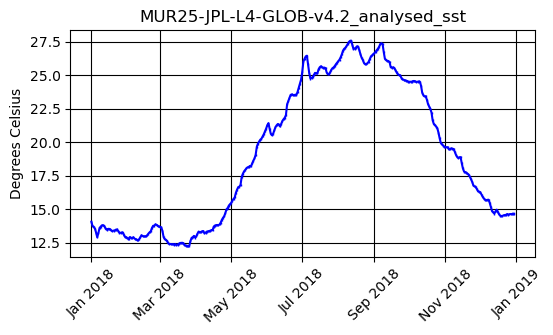

In [6]:
# Plot the result
print("Plot of area-average time series:")
ts_plot(ts_json, val_name='mean', title=dataset_us, units='Degrees Celsius')

## Time Averaged Map
Next we will issue an SDAP web service call to compute a time averaged map.  While the time series algorithm used above averages spatially to produce a single value for each time stamp, the time average map averages over time to produce a single value at each grid cell location.  While the time series produces a 1D result indexed by time, the time averaged map produces a 2D map indexed by latitude and longitude.

In [7]:
# Compute time-averaged map using the SDAP/NEXUS web/HTTP interface
#
# Construct the URL
url = '{}/timeAvgMapSpark?ds={}&minLon={}&minLat={}&maxLon={}&maxLat={}&startTime={}&endTime={}'.\
    format(base_url_us, dataset_us, *bbox.bounds, 
           start_time.strftime(dt_format), end_time.strftime(dt_format))

# Display some information about the job
print(url); print()

# Query SDAP to compute the time averaged map
print("Waiting for response from SDAP...")
start = time.perf_counter()
tam_json = requests.get(url, verify=False).json()
print("Time averaged map took {} seconds".format(time.perf_counter() - start))

https://coverage.ceos.org/nexus/timeAvgMapSpark?ds=MUR25-JPL-L4-GLOB-v4.2_analysed_sst&minLon=-77.0&minLat=35.0&maxLon=-70.0&maxLat=42.0&startTime=2018-01-01T00:00:00Z&endTime=2018-12-31T00:00:00Z

Waiting for response from SDAP...
Time averaged map took 2.542372552 seconds


### JSON response
The SDAP web service calls return the result in `JSON`, a standard web services data
interchange format.  This makes it easy for another web service component to "consume" the SDAP output.
Let's view the JSON response.  It is long, so we'll show just the first few grid cells.

In [8]:
show_sdap_json(tam_json, nh=13, nt=10)

{'data': [[{'cnt': 0, 'lat': 35.125, 'lon': -76.875, 'mean': -9999.0},
           {'cnt': 364,
            'lat': 35.125,
            'lon': -76.625,
            'mean': 19.30176594493153},
           {'cnt': 364,
            'lat': 35.125,
            'lon': -76.375,
            'mean': 19.900902297470594},
           {'cnt': 364,
            'lat': 35.125,
            'lon': -76.125,
            'mean': 20.50982372577374},
		.
		.
		.

 'meta': {'bounds': {'east': -70.0,
                     'north': 42.0,
                     'south': 35.0,
                     'west': -77.0},
          'shortName': 'MUR25-JPL-L4-GLOB-v4.2_analysed_sst',
          'time': {'iso_start': '2018-01-01T00:00:00+0000',
                   'iso_stop': '2018-12-31T00:00:00+0000',
                   'start': 1514764800,
                   'stop': 1546214400}},
 'stats': {}}


### Extract the actual data and plot the result
The actual time averaged map data is readily accessible for plotting.

Creating plot of the results.
This will take a minute.  Please wait...


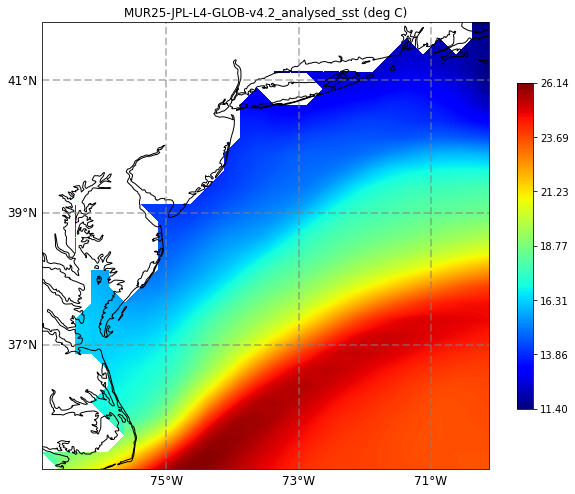

In [9]:
# Extract the actual output data
tam = tam_json["data"]

# Create a plot of the Time Averaged Map results
plot_map(tam, title=dataset_us+" (deg C)", grid_line_sep=2)

## Hovmoller Maps
Next we will issue an SDAP web service call to compute latitude-time and longitude-time Hovmoller maps and plot the results.

In [10]:
# Construct the URLs
url_lat = '{}/latitudeTimeHofMoellerSpark?ds={}&minLon={}&minLat={}&maxLon={}&maxLat={}&startTime={}&endTime={}'.\
    format(base_url_us, dataset_us, *bbox.bounds, 
           start_time.strftime(dt_format), end_time.strftime(dt_format))
url_lon = '{}/longitudeTimeHofMoellerSpark?ds={}&minLon={}&minLat={}&maxLon={}&maxLat={}&startTime={}&endTime={}'.\
    format(base_url_us, dataset_us, *bbox.bounds, 
           start_time.strftime(dt_format), end_time.strftime(dt_format))

# Query SDAP to compute the latitude-time Hovmoller map
print(url_lat); print()
print("Waiting for response from SDAP...")
start = time.perf_counter()
hm_lat_json = requests.get(url_lat, verify=False).json()
print("Latitude-time Hovmoller map took {} seconds".format(time.perf_counter() - start)); print()

# Query SDAP to compute the longitude-time Hovmoller map
print(url_lon); print()
print("Waiting for response from SDAP...")
start = time.perf_counter()
hm_lon_json = requests.get(url_lon, verify=False).json()
print("Longitude-time Hovmoller map took {} seconds".format(time.perf_counter() - start))


https://coverage.ceos.org/nexus/latitudeTimeHofMoellerSpark?ds=MUR25-JPL-L4-GLOB-v4.2_analysed_sst&minLon=-77.0&minLat=35.0&maxLon=-70.0&maxLat=42.0&startTime=2018-01-01T00:00:00Z&endTime=2018-12-31T00:00:00Z

Waiting for response from SDAP...
Latitude-time Hovmoller map took 7.162608430999999 seconds

https://coverage.ceos.org/nexus/longitudeTimeHofMoellerSpark?ds=MUR25-JPL-L4-GLOB-v4.2_analysed_sst&minLon=-77.0&minLat=35.0&maxLon=-70.0&maxLat=42.0&startTime=2018-01-01T00:00:00Z&endTime=2018-12-31T00:00:00Z

Waiting for response from SDAP...
Longitude-time Hovmoller map took 5.608518793999998 seconds


### JSON response
Let's view the JSON response. It is long, so we'll show just the first few grid cells.

In [11]:
# Show snippet of JSON response for latitude-time Hovmoller
show_sdap_json(hm_lat_json, nh=19, nt=10)

{'data': [{'iso_time': '2018-01-01T09:00:00Z',
           'lats': [{'cnt': 27,
                     'latitude': 35.125,
                     'max': 23.985992431640625,
                     'mean': 20.459851300274885,
                     'min': 10.618988037109375,
                     'std': 3.1210128018288916},
                    {'cnt': 28,
                     'latitude': 35.375,
                     'max': 23.951995849609375,
                     'mean': 19.137821742466517,
                     'min': 7.498992919921875,
                     'std': 4.428031393356866},
                    {'cnt': 23,
                     'latitude': 35.625,
                     'max': 24.0780029296875,
                     'mean': 20.333522630774457,
                     'min': 11.97601318359375,
                     'std': 2.984152309372665},
		.
		.
		.

 'meta': {'bounds': {'east': -70.0,
                     'north': 42.0,
                     'south': 35.0,
                     'west': -77.0},


In [12]:
# Show snippet of JSON response for longitude-time Hovmoller
show_sdap_json(hm_lon_json, nh=19, nt=10)

{'data': [{'iso_time': '2018-01-01T09:00:00Z',
           'lons': [{'cnt': 2,
                     'longitude': -76.875,
                     'max': 7.498992919921875,
                     'mean': 5.190556277946424,
                     'min': 2.805999755859375,
                     'std': 3.3184474557792023},
                    {'cnt': 3,
                     'longitude': -76.625,
                     'max': 10.618988037109375,
                     'mean': 7.698111270561268,
                     'min': 3.343994140625,
                     'std': 3.770048694421828},
                    {'cnt': 9,
                     'longitude': -76.375,
                     'max': 12.608001708984375,
                     'mean': 5.3454034373768025,
                     'min': 2.621002197265625,
                     'std': 3.3837299215520678},
		.
		.
		.

 'meta': {'bounds': {'east': -70.0,
                     'north': 42.0,
                     'south': 35.0,
                     'west': -77.0},
 

### Extract the actual data and plot the results
The actual map data is readily accessible for plotting.

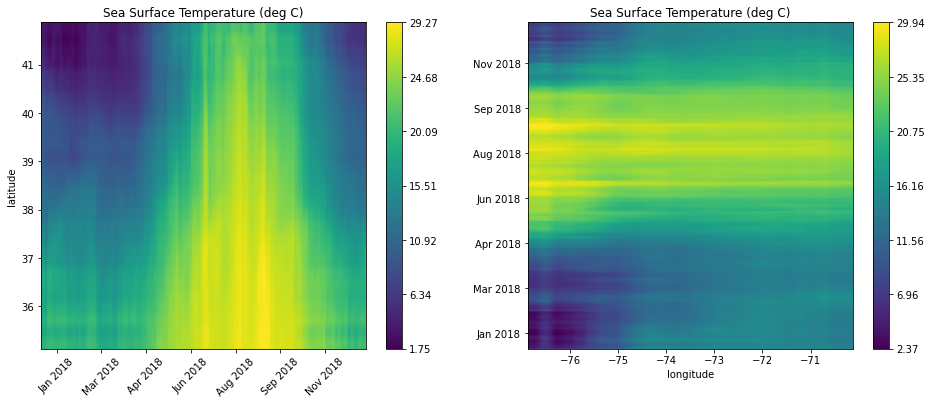

In [13]:
# Extract the actual output data
hm_lat = hm_lat_json["data"]
hm_lon = hm_lon_json["data"]

# Plot the Hovmoller maps
hovfig = plot_hovmoller(hm_lat, coord_series_key="lats", coord_point_key="latitude", 
                        coord_axis_vert=True, subplot=121, 
                        title="Sea Surface Temperature (deg C)")
hovfig = plot_hovmoller(hm_lon, coord_series_key="lons", coord_point_key="longitude",
                        coord_axis_vert=False, hovfig=hovfig, subplot=122,
                        title="Sea Surface Temperature (deg C)")

## Joint Analytics Across AWS and WEkEO SDAP Deployments
Next we can take advantage of the two SDAP deployments and conduct joint analytics across the two platforms.
### Compare two SST datasets, one from AWS SDAP and one from WEkEO SDAP

In [14]:
# Previous time series result was computed on AWS with
# dataset "MUR25-JPL-L4-GLOB-v4.2_analysed_sst"
ts_mur25_json = ts_json

# Let's compute a 2nd SST time series, this time computed on WEkEO with
# dataset "METOFFICE-GLO-SST-L4-NRT-OBS-GMPE-V3_analysed_sst"
#
dataset_eu_gmpe_sst = "METOFFICE-GLO-SST-L4-NRT-OBS-GMPE-V3_analysed_sst"
url = '{}/timeSeriesSpark?ds={}&minLon={}&minLat={}&maxLon={}&maxLat={}&startTime={}&endTime={}&seasonalFilter={}'.\
    format(base_url_eu, dataset_eu_gmpe_sst, *bbox.bounds, 
           start_time.strftime(dt_format), end_time.strftime(dt_format),
           "false")

# Display some information about the job
print(url); print()

# Query SDAP to compute the time averaged map
print("Waiting for response from SDAP...")
start = time.perf_counter()
ts_gmpe_json = requests.get(url, verify=False).json()
print("Time series took {} seconds".format(time.perf_counter() - start))

https://coverage.wekeo.eu/timeSeriesSpark?ds=METOFFICE-GLO-SST-L4-NRT-OBS-GMPE-V3_analysed_sst&minLon=-77.0&minLat=35.0&maxLon=-70.0&maxLat=42.0&startTime=2018-01-01T00:00:00Z&endTime=2018-12-31T00:00:00Z&seasonalFilter=false

Waiting for response from SDAP...
Time series took 5.067509015999999 seconds


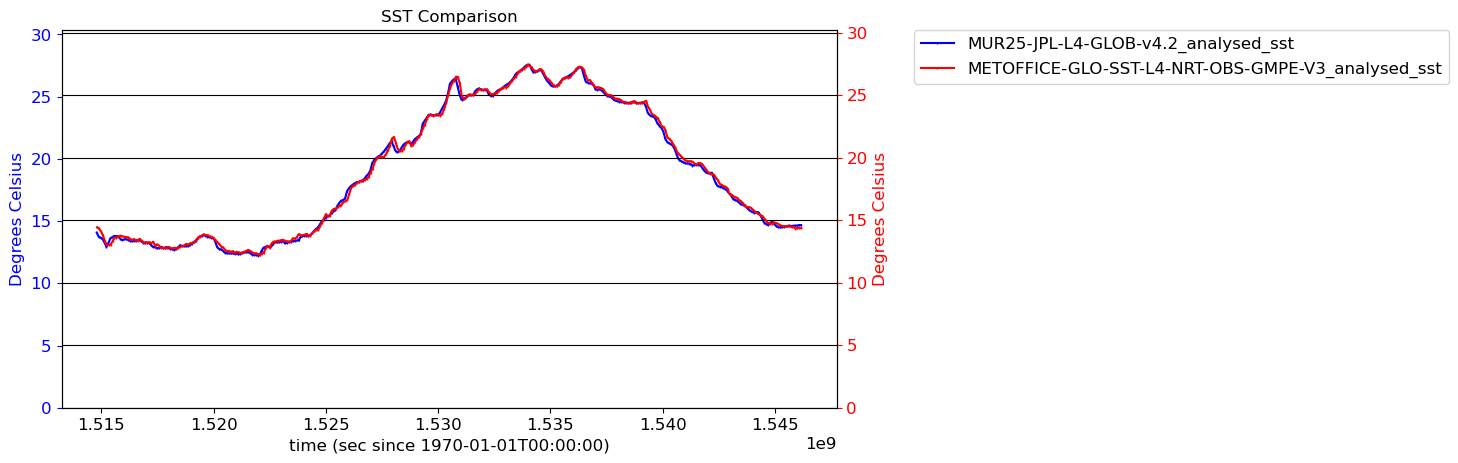

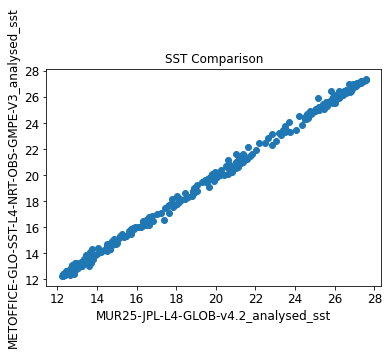

In [15]:
# Plot the result
ts_plot_two(ts_mur25_json, ts_gmpe_json, dataset_us, dataset_eu_gmpe_sst, 
            "Degrees Celsius", "Degrees Celsius",
            title="SST Comparison", val_name="mean")
scatter_plot(ts_mur25_json, ts_gmpe_json, title="SST Comparison",
             xlabel=dataset_us, ylabel=dataset_eu_gmpe_sst)

### Compare SST from AWS SDAP and ADT from WEkEO SDAP

In [16]:
dataset_eu_cmems_adt = "CMEMS_AVISO_SEALEVEL_GLO_PHY_L4_REP_OBSERVATIONS_008_047_adt"
url = '{}/timeSeriesSpark?ds={}&minLon={}&minLat={}&maxLon={}&maxLat={}&startTime={}&endTime={}&seasonalFilter={}'.\
    format(base_url_eu, dataset_eu_cmems_adt, *bbox.bounds, 
           start_time.strftime(dt_format), end_time.strftime(dt_format),
           "false")

# Display some information about the job
print(url); print()

# Query SDAP to compute the time averaged map
print("Waiting for response from SDAP...")
start = time.perf_counter()
ts_cmems_adt_json = requests.get(url, verify=False).json()
print("Time series took {} seconds".format(time.perf_counter() - start))

https://coverage.wekeo.eu/timeSeriesSpark?ds=CMEMS_AVISO_SEALEVEL_GLO_PHY_L4_REP_OBSERVATIONS_008_047_adt&minLon=-77.0&minLat=35.0&maxLon=-70.0&maxLat=42.0&startTime=2018-01-01T00:00:00Z&endTime=2018-12-31T00:00:00Z&seasonalFilter=false

Waiting for response from SDAP...
Time series took 2.8681450229999967 seconds


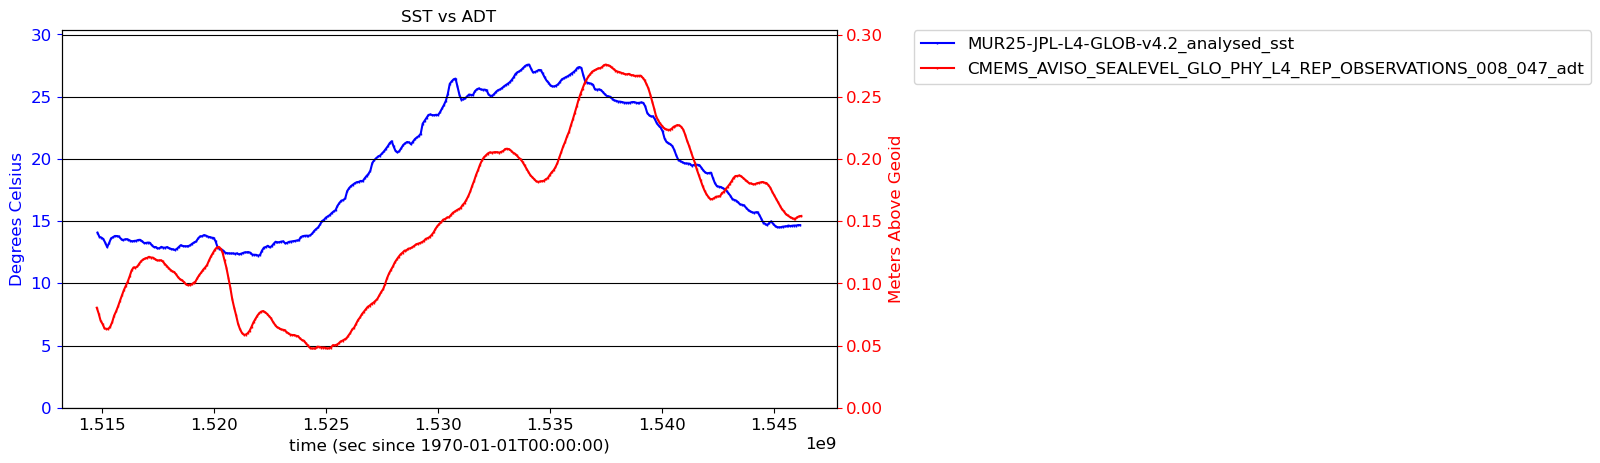

In [17]:
# Plot the result
ts_plot_two(ts_mur25_json, ts_cmems_adt_json, dataset_us, dataset_eu_cmems_adt, 
            "Degrees Celsius", "Meters Above Geoid",
            title="SST vs ADT", val_name="mean")

# More SDAP Analytics
In the rest of this notebook we use a helper function defined in the first notebook cell above to use SDAP to compute time series and time averaged map for a variety of other relevant datasets.  In these results, SDAP is used in the same way as we demonstrated above.

## Absolute Dynamic Topography (ADT) from CMEMS_AVISO_SEALEVEL_GLO_PHY_L4_REP_OBSERVATIONS_008_047

https://coverage.wekeo.eu/timeSeriesSpark?ds=CMEMS_AVISO_SEALEVEL_GLO_PHY_L4_REP_OBSERVATIONS_008_047_adt&minLon=-77.0&minLat=35.0&maxLon=-70.0&maxLat=42.0&startTime=2018-01-01T00:00:00Z&endTime=2018-12-31T00:00:00Z&seasonalFilter=false

https://coverage.wekeo.eu/timeAvgMapSpark?ds=CMEMS_AVISO_SEALEVEL_GLO_PHY_L4_REP_OBSERVATIONS_008_047_adt&minLon=-77.0&minLat=35.0&maxLon=-70.0&maxLat=42.0&startTime=2018-01-01T00:00:00Z&endTime=2018-12-31T00:00:00Z

Computing time series...
Area-averaged time series took 2.711047131000001 seconds

Computing time averaged map...
Time averaged map took 2.9513561680000038 seconds

Plot of area-average time series:


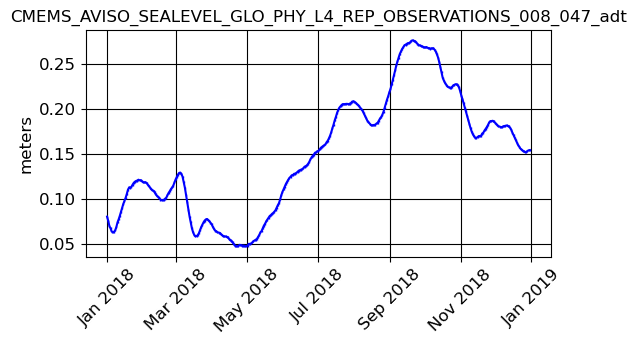

Creating plot of the results.
This will take a minute.  Please wait...


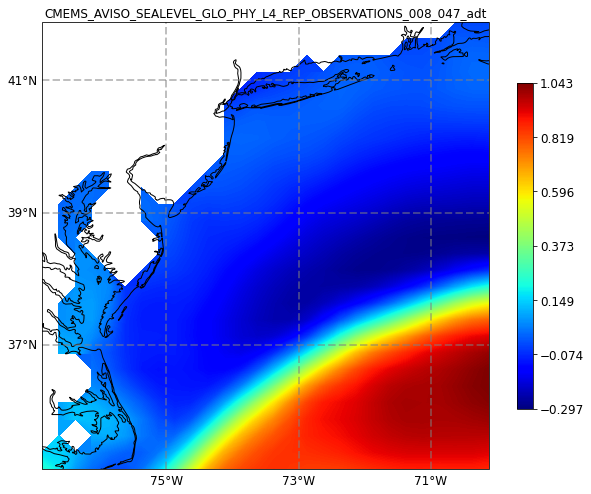

In [18]:
dataset = "CMEMS_AVISO_SEALEVEL_GLO_PHY_L4_REP_OBSERVATIONS_008_047_adt"
compute_ts_and_tam(dataset,
                   bbox, start_time, end_time, base_url=base_url_eu, 
                   units="meters", title=dataset, grid_line_sep=2)

## Sea Level Anomaly (SLA) from CMEMS_AVISO_SEALEVEL_GLO_PHY_L4_REP_OBSERVATIONS_008_047

https://coverage.wekeo.eu/timeSeriesSpark?ds=CMEMS_AVISO_SEALEVEL_GLO_PHY_L4_REP_OBSERVATIONS_008_047_sla&minLon=-77.0&minLat=35.0&maxLon=-70.0&maxLat=42.0&startTime=2018-01-01T00:00:00Z&endTime=2018-12-31T00:00:00Z&seasonalFilter=false

https://coverage.wekeo.eu/timeAvgMapSpark?ds=CMEMS_AVISO_SEALEVEL_GLO_PHY_L4_REP_OBSERVATIONS_008_047_sla&minLon=-77.0&minLat=35.0&maxLon=-70.0&maxLat=42.0&startTime=2018-01-01T00:00:00Z&endTime=2018-12-31T00:00:00Z

Computing time series...
Area-averaged time series took 2.6760018169999995 seconds

Computing time averaged map...
Time averaged map took 3.000335100000001 seconds

Plot of area-average time series:


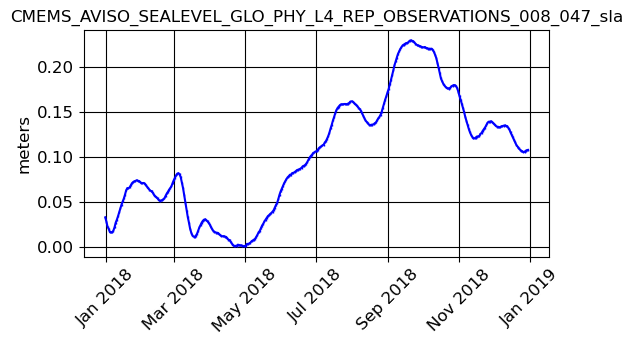

Creating plot of the results.
This will take a minute.  Please wait...


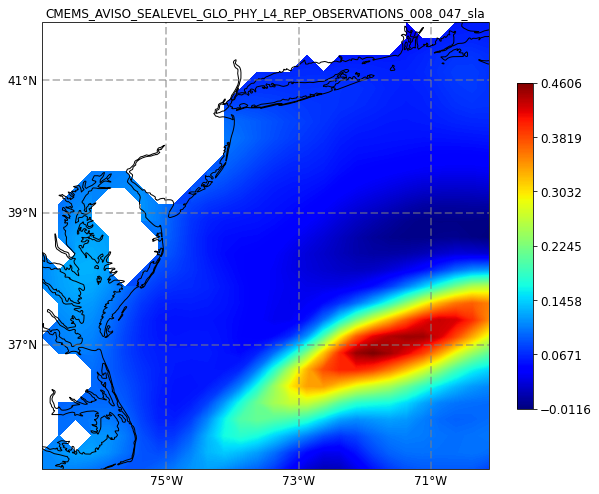

In [19]:
dataset = "CMEMS_AVISO_SEALEVEL_GLO_PHY_L4_REP_OBSERVATIONS_008_047_sla"
compute_ts_and_tam(dataset, 
                   bbox, start_time, end_time, base_url=base_url_eu, 
                   units="meters", title=dataset, grid_line_sep=2)

## Sea Surface Salinity (SSS) from Multi-Mission Optimally Interpolated Sea Surface Salinity 7-Day Global Dataset V1

https://coverage.ceos.org/nexus/timeSeriesSpark?ds=OISSS_L4_multimission_global_7d_v1.0_sss&minLon=-77.0&minLat=35.0&maxLon=-70.0&maxLat=42.0&startTime=2018-01-01T00:00:00Z&endTime=2018-12-31T00:00:00Z&seasonalFilter=false

https://coverage.ceos.org/nexus/timeAvgMapSpark?ds=OISSS_L4_multimission_global_7d_v1.0_sss&minLon=-77.0&minLat=35.0&maxLon=-70.0&maxLat=42.0&startTime=2018-01-01T00:00:00Z&endTime=2018-12-31T00:00:00Z

Computing time series...
Area-averaged time series took 0.7783665330000034 seconds

Computing time averaged map...
Time averaged map took 1.0058264760000029 seconds

Plot of area-average time series:


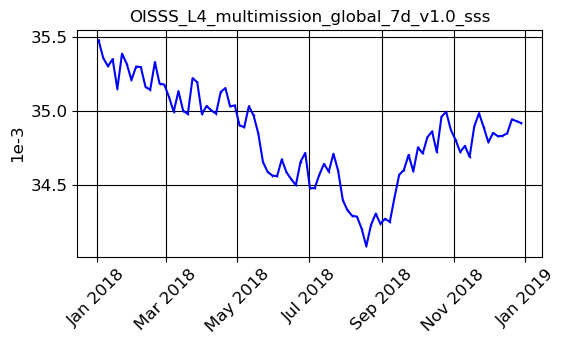

Creating plot of the results.
This will take a minute.  Please wait...


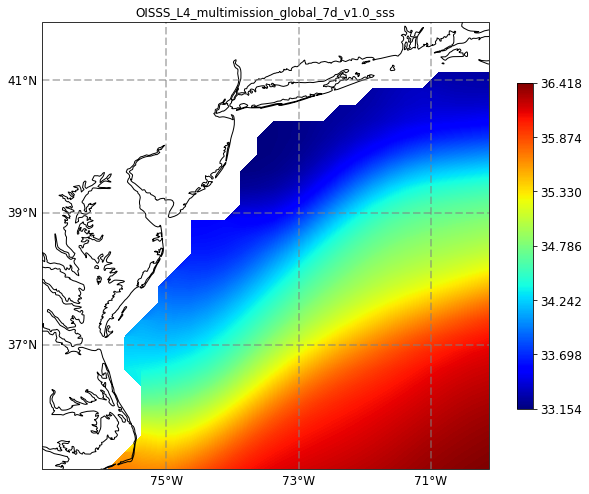

In [20]:
dataset = "OISSS_L4_multimission_global_7d_v1.0_sss"
compute_ts_and_tam(dataset, 
                   bbox, start_time, end_time, base_url=base_url_us, 
                   units="1e-3", title=dataset, grid_line_sep=2)

## Sea Surface Temperature (SST) from MUR25-JPL-L4-GLOB-v4.2

https://coverage.ceos.org/nexus/timeSeriesSpark?ds=MUR25-JPL-L4-GLOB-v4.2_analysed_sst&minLon=-77.0&minLat=35.0&maxLon=-70.0&maxLat=42.0&startTime=2018-01-01T00:00:00Z&endTime=2018-12-31T00:00:00Z&seasonalFilter=false

https://coverage.ceos.org/nexus/timeAvgMapSpark?ds=MUR25-JPL-L4-GLOB-v4.2_analysed_sst&minLon=-77.0&minLat=35.0&maxLon=-70.0&maxLat=42.0&startTime=2018-01-01T00:00:00Z&endTime=2018-12-31T00:00:00Z

Computing time series...
Area-averaged time series took 1.0993870109999975 seconds

Computing time averaged map...
Time averaged map took 1.4075893969999953 seconds

Plot of area-average time series:


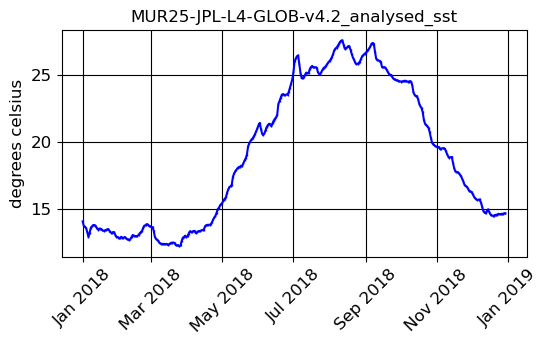

Creating plot of the results.
This will take a minute.  Please wait...


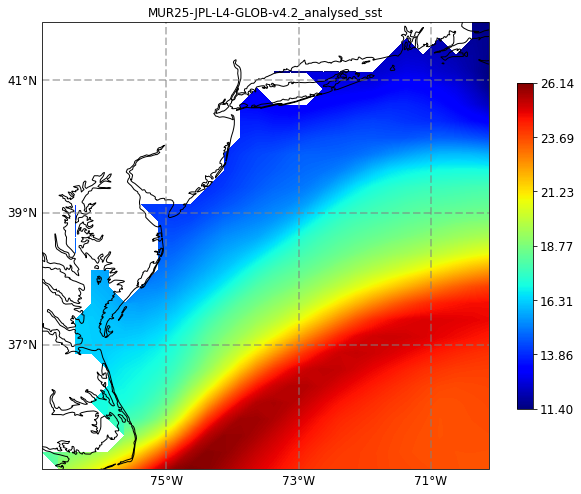

In [21]:
dataset = "MUR25-JPL-L4-GLOB-v4.2_analysed_sst"
compute_ts_and_tam(dataset, 
                   bbox, start_time, end_time, base_url=base_url_us, 
                   units="degrees celsius", title=dataset, grid_line_sep=2)

## Chlorophyll-A from MODIS_Aqua_L3m_8D

https://coverage.ceos.org/nexus/timeSeriesSpark?ds=MODIS_Aqua_L3m_8D_chlor_a&minLon=-77.0&minLat=35.0&maxLon=-70.0&maxLat=42.0&startTime=2018-01-01T00:00:00Z&endTime=2018-12-31T00:00:00Z&seasonalFilter=true

https://coverage.ceos.org/nexus/timeAvgMapSpark?ds=MODIS_Aqua_L3m_8D_chlor_a&minLon=-77.0&minLat=35.0&maxLon=-70.0&maxLat=42.0&startTime=2018-01-01T00:00:00Z&endTime=2018-12-31T00:00:00Z

Computing time series...
Area-averaged time series took 0.6416215519999966 seconds

Computing time averaged map...
Time averaged map took 3.344425043000001 seconds

Plot of area-average time series:


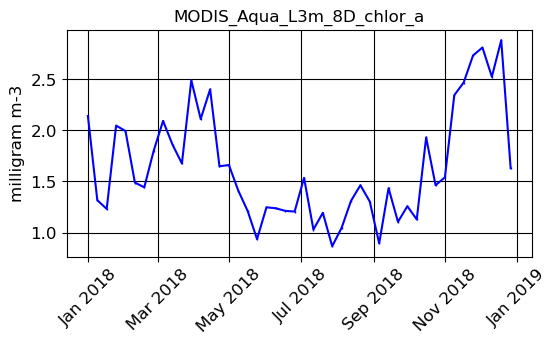

Plot of time series of difference with climatology:


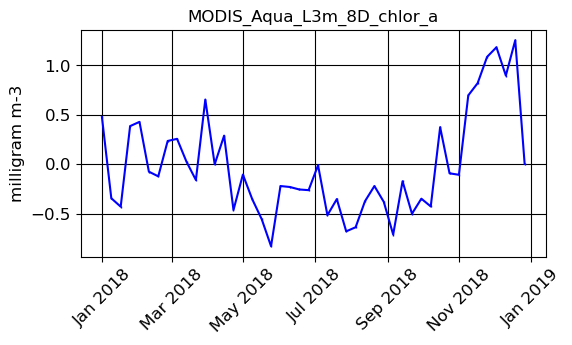


Creating plot of the results.
This will take a minute.  Please wait...


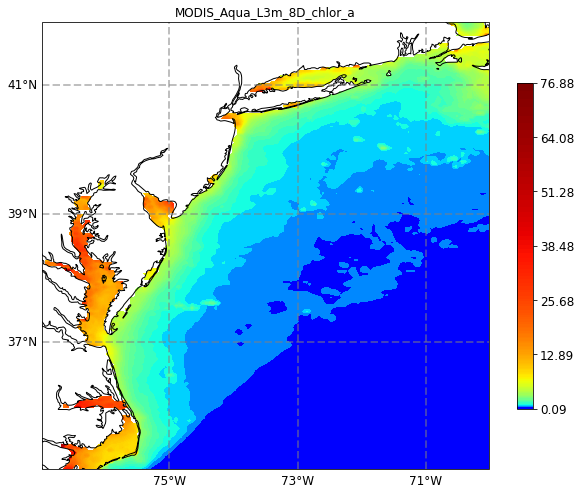

In [22]:
# Define dataset and bounding box for analysis
dataset = "MODIS_Aqua_L3m_8D_chlor_a"
compute_ts_and_tam(dataset, 
                   bbox, start_time, end_time, base_url=base_url_us,
                   seasonal_filter="true",
                   units="milligram m-3", title=dataset,
                   log_colors=True, grid_line_sep=2)

## Chlorophyll-A from JPL-MRVA25-CHL-L4-GLOB-v3.0_CHLA

https://coverage.ceos.org/nexus/timeSeriesSpark?ds=JPL-MRVA25-CHL-L4-GLOB-v3.0_CHLA_analysis&minLon=-77.0&minLat=35.0&maxLon=-70.0&maxLat=42.0&startTime=2018-01-01T00:00:00Z&endTime=2018-12-31T00:00:00Z&seasonalFilter=false

https://coverage.ceos.org/nexus/timeAvgMapSpark?ds=JPL-MRVA25-CHL-L4-GLOB-v3.0_CHLA_analysis&minLon=-77.0&minLat=35.0&maxLon=-70.0&maxLat=42.0&startTime=2018-01-01T00:00:00Z&endTime=2018-12-31T00:00:00Z

Computing time series...
Area-averaged time series took 1.0853988900000004 seconds

Computing time averaged map...
Time averaged map took 1.406688213999999 seconds

Plot of area-average time series:


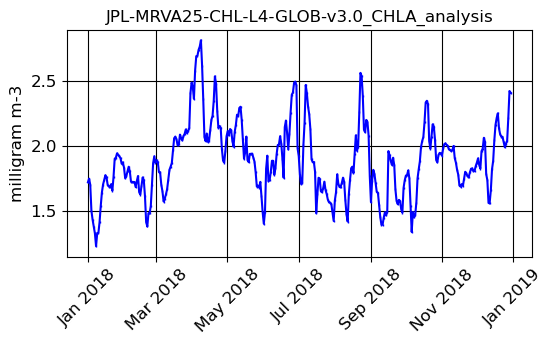

Creating plot of the results.
This will take a minute.  Please wait...


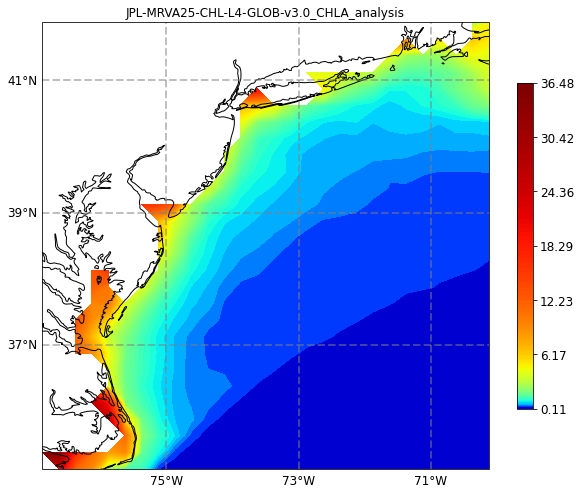

In [23]:
dataset = "JPL-MRVA25-CHL-L4-GLOB-v3.0_CHLA_analysis"
compute_ts_and_tam(dataset, 
                   bbox, start_time, end_time, base_url=base_url_us, 
                   units="milligram m-3", title=dataset, log_colors=True,
                   grid_line_sep=2)

## Chlorophyll-A from CMEMS_OCEANCOLOUR_GLO_CHL_L4_REP_OBSERVATIONS_009_082

https://coverage.wekeo.eu/timeSeriesSpark?ds=CMEMS_OCEANCOLOUR_GLO_CHL_L4_REP_OBSERVATIONS_009_082_CHL&minLon=-77.0&minLat=35.0&maxLon=-70.0&maxLat=42.0&startTime=2018-01-01T00:00:00Z&endTime=2018-12-31T00:00:00Z&seasonalFilter=false

https://coverage.wekeo.eu/timeAvgMapSpark?ds=CMEMS_OCEANCOLOUR_GLO_CHL_L4_REP_OBSERVATIONS_009_082_CHL&minLon=-77.0&minLat=35.0&maxLon=-70.0&maxLat=42.0&startTime=2018-01-01T00:00:00Z&endTime=2018-12-31T00:00:00Z

Computing time series...
Area-averaged time series took 3.2690633870000028 seconds

Computing time averaged map...
Time averaged map took 5.265567097000002 seconds

Plot of area-average time series:


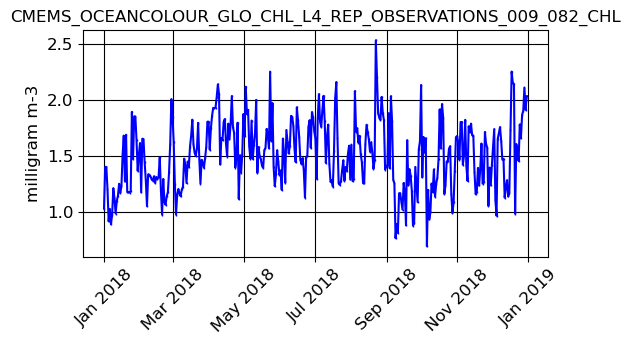

Creating plot of the results.
This will take a minute.  Please wait...


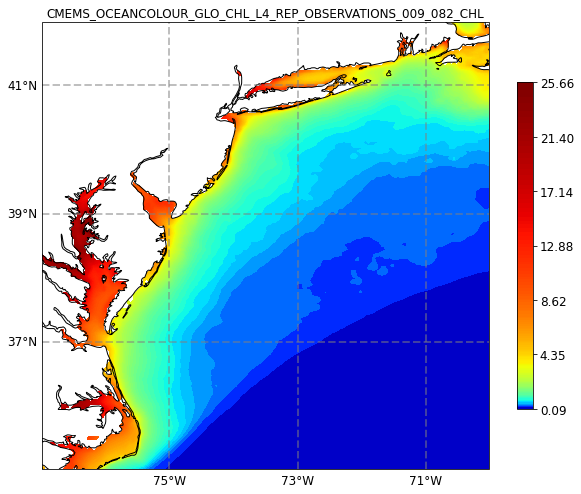

In [24]:
dataset = "CMEMS_OCEANCOLOUR_GLO_CHL_L4_REP_OBSERVATIONS_009_082_CHL"
compute_ts_and_tam(dataset, 
                   bbox, start_time, end_time, base_url=base_url_eu, 
                   units="milligram m-3", title=dataset, log_colors=True,
                   grid_line_sep=2)